In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.drr import DRR, Registration
from diffdrr.data import load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

np.random.seed(39)

In [ ]:
def converged(df):
    return df["loss"].iloc[-1] <= -0.999

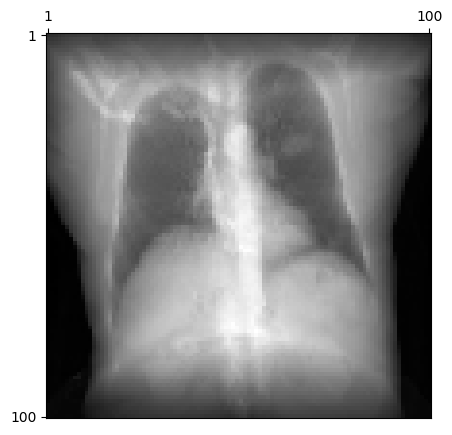

In [ ]:
#|cuda
# Make the ground truth X-ray
SDR = 300.0
HEIGHT = 100
DELX = 8.0

volume, spacing = load_example_ct()
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
true_params = {
    "sdr": SDR,
    "theta": torch.pi,
    "phi": 0,
    "gamma": torch.pi / 2,
    "bx": bx,
    "by": by,
    "bz": bz,
}
device = ("cuda" if torch.cuda.is_available() else "cpu")

drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
rotations = torch.tensor([[true_params["theta"], true_params["phi"], true_params["gamma"]]]).to(device)
translations = torch.tensor([[true_params["bx"], true_params["by"], true_params["bz"]]]).to(device)
ground_truth = drr(rotations, translations)

plot_drr(ground_truth)
plt.show()

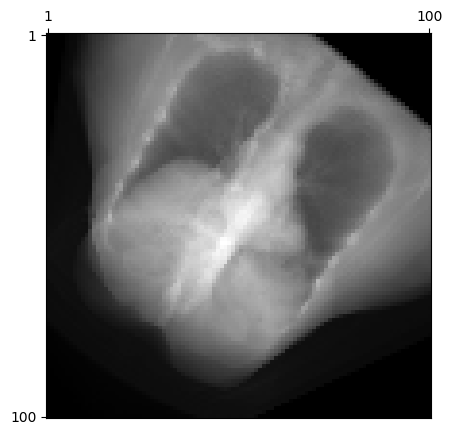

In [ ]:
#|cuda
# Make a random DRR
def get_initial_parameters(true_params):
    theta = true_params["theta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    phi = true_params["phi"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    return torch.tensor([[theta, phi, gamma]]).to(device), torch.tensor([[bx, by, bz]]).to(device)


rotations, translations = get_initial_parameters(true_params)
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
with torch.no_grad():
    est = drr(rotations, translations)
plot_drr(est)
plt.show()

In [ ]:
def optimize(
    reg: Registration,
    ground_truth,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250
):
    criterion = XCorr2(zero_mean_normalized=True)
    optimizer = torch.optim.SGD(
        [
            {"params": [reg.rotations], "lr": lr_rotations},
            {"params": [reg.translations], "lr": lr_translations},
        ],
        momentum=momentum,
        dampening=dampening,
    )
    
    params = []
    for itr in tqdm(range(n_itrs)):
        # Save the current set of parameters
        theta, phi, gamma = reg.rotations.squeeze().tolist()
        bx, by, bz = reg.translations.squeeze().tolist()
        params.append([i for i in [theta, phi, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = reg()
        loss = -criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if loss < -0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break
        
    return pd.DataFrame(params, columns=["theta", "phi", "gamma", "bx", "by", "bz"])

In [ ]:
#|cuda
# Base SGD
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(drr, rotations.clone(), translations.clone())
params_base = optimize(reg, ground_truth)
del drr

# SGD + momentum
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(drr, rotations.clone(), translations.clone())
params_momentum = optimize(reg, ground_truth, momentum=0.9)
del drr

# SGD + momentum + dampening
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)
reg = Registration(drr, rotations.clone(), translations.clone())
params_momentum_dampen = optimize(reg, ground_truth, momentum=0.9, dampening=0.1)
del drr

 55%|█████████████████████████████████████████▉                                  | 138/250 [00:02<00:02, 50.52it/s]


Converged in 138 iterations


 24%|██████████████████▊                                                          | 61/250 [00:01<00:03, 49.72it/s]


Converged in 61 iterations


 26%|████████████████████                                                         | 65/250 [00:01<00:03, 49.47it/s]

Converged in 65 iterations


In [ ]:
from IPython.display import display, HTML
from base64 import b64encode

from diffdrr.visualization import animate

In [ ]:
def animate_in_browser(df):
    out = animate("<bytes>", df, drr, ground_truth, verbose=True, device=device, extension=".webp", duration=30)
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))

In [ ]:
#|cuda
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(device)

In [ ]:
#|cuda
animate_in_browser(params_base)

Precomputing DRRs: 100%|█████████████████████████████████████████████████████████| 139/139 [00:28<00:00,  4.93it/s]


In [ ]:
#|cuda
animate_in_browser(params_momentum)

Precomputing DRRs: 100%|███████████████████████████████████████████████████████████| 62/62 [00:13<00:00,  4.77it/s]


In [ ]:
#|cuda
animate_in_browser(params_momentum_dampen)

Precomputing DRRs: 100%|███████████████████████████████████████████████████████████| 66/66 [00:13<00:00,  4.95it/s]
